In [4]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [27]:
### Image Insertion ###

f = nd2.ND2File(img_path)
image = f.asarray()

DAPI_stack = to_8bit(image[:,0,:,:].copy())
eGFP_stack = to_8bit(image[:,1,:,:].copy())
WGA_stack = to_8bit(image[:,2,:,:].copy())

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

C:\Users\Luis\AppData\Local\Temp\ipykernel_2540\87014615.py:3: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(img_path)


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


(-0.5, 1023.5, 1023.5, -0.5)

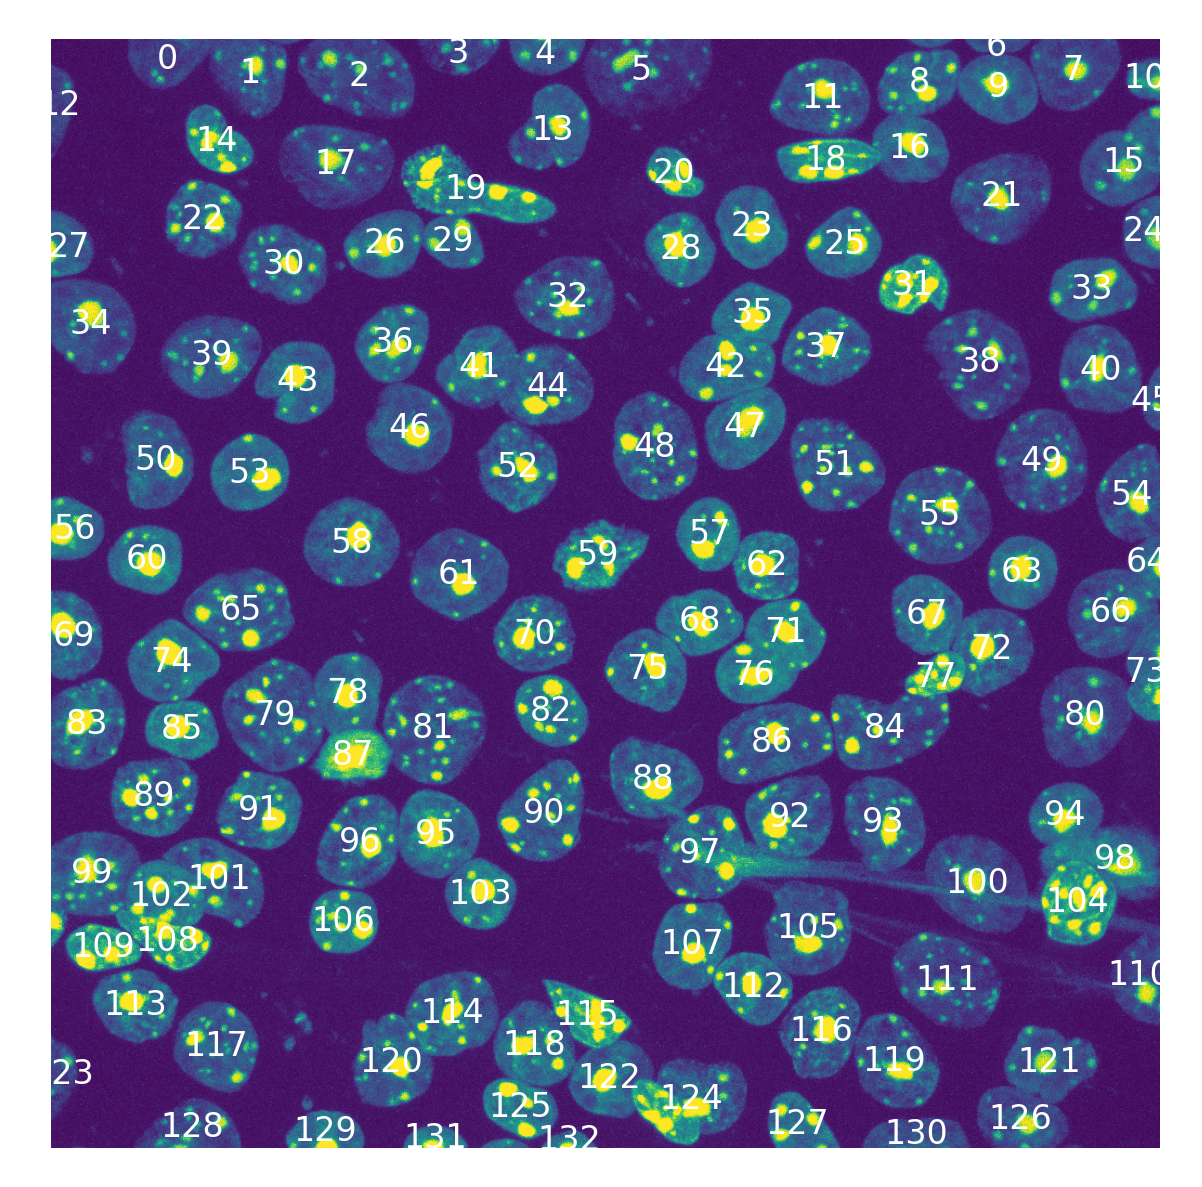

In [5]:
DAPI_coords = get_nuclei_position(DAPI_masks)
plt.imshow(mp_DAPI)
plot_maskids(DAPI_coords, text_color = 'white', font_size= 8)
plt.axis('off')

In [6]:
def square_mask(mask, perc_increase: int = 40):
    labeled_mask = measure.label(mask)
    regions = measure.regionprops(labeled_mask)
    largest_region = max(regions, key=lambda r: r.area)

    min_row, min_col, max_row, max_col = largest_region.bbox
    centroid = largest_region.centroid

    height = max_row - min_row
    width = max_col - min_col
    diameter = max(height, width)
    new_diameter = diameter * (1 + perc_increase / 100)
    half_side = new_diameter / 2

    top_left = (int(centroid[0] - half_side), int(centroid[1] - half_side))
    bottom_right = (int(centroid[0] + half_side), int(centroid[1] + half_side))

    top_left = (max(top_left[0], 0), max(top_left[1], 0))
    bottom_right = (min(bottom_right[0], mask.shape[0]), min(bottom_right[1], mask.shape[1]))

    new_mask = np.zeros_like(mask)
    new_mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 1

    return new_mask

def WGA_projector(DAPI_stack, WGA_stack, single_mask, z_sep):
    sq_maski = square_mask(single_mask, perc_increase=10)
    comzi = nucleus_com(DAPI_stack, single_mask)
    if comzi is None:
        return None, sq_maski

    above_and_below = int(0.5 / z_sep)
    min_slice = max(0, comzi[2] - above_and_below)
    max_slice = min(WGA_stack.shape[0], comzi[2] + above_and_below + 1)

    sq_stack = WGA_stack[min_slice:max_slice] * sq_maski

    sq_stack = ~auto_brightness_contrast(max_proj(~sq_stack))

    return sq_stack, sq_maski

def WGA_stitcher(DAPI_stack, WGA_stack, masks, z_sep):
    z_avg = int(np.mean(nuclei_slices(DAPI_stack, masks)))
    base_stack = auto_brightness_contrast(WGA_stack[z_avg])

    total_masks = np.delete(np.unique(masks), 0)

    for mask_num in total_masks:
        maski = masks == mask_num
        sq_stacki, sq_maski = WGA_projector(DAPI_stack, WGA_stack, maski, z_sep)
        if sq_stacki is not None:
            base_stack[sq_maski] = sq_stacki[sq_maski]

    plt.imshow(base_stack)
    plt.axis('off')
    return base_stack

def nucleus_com(single_channel, masks):
    total_masks = np.delete(np.unique(masks), 0)
    if total_masks.size == 0:
        return None

    mask = total_masks[0]
    single_mask = masks == mask
    masked_channel = single_channel * single_mask

    z_prof = np.sum(masked_channel, axis=(1, 2))
    z_max_idx = np.argmax(z_prof)

    com = center_of_mass(single_mask)
    if np.isnan(com).any():
        return None

    com_3d = (int(com[0]), int(com[1]), z_max_idx)
    return com_3d

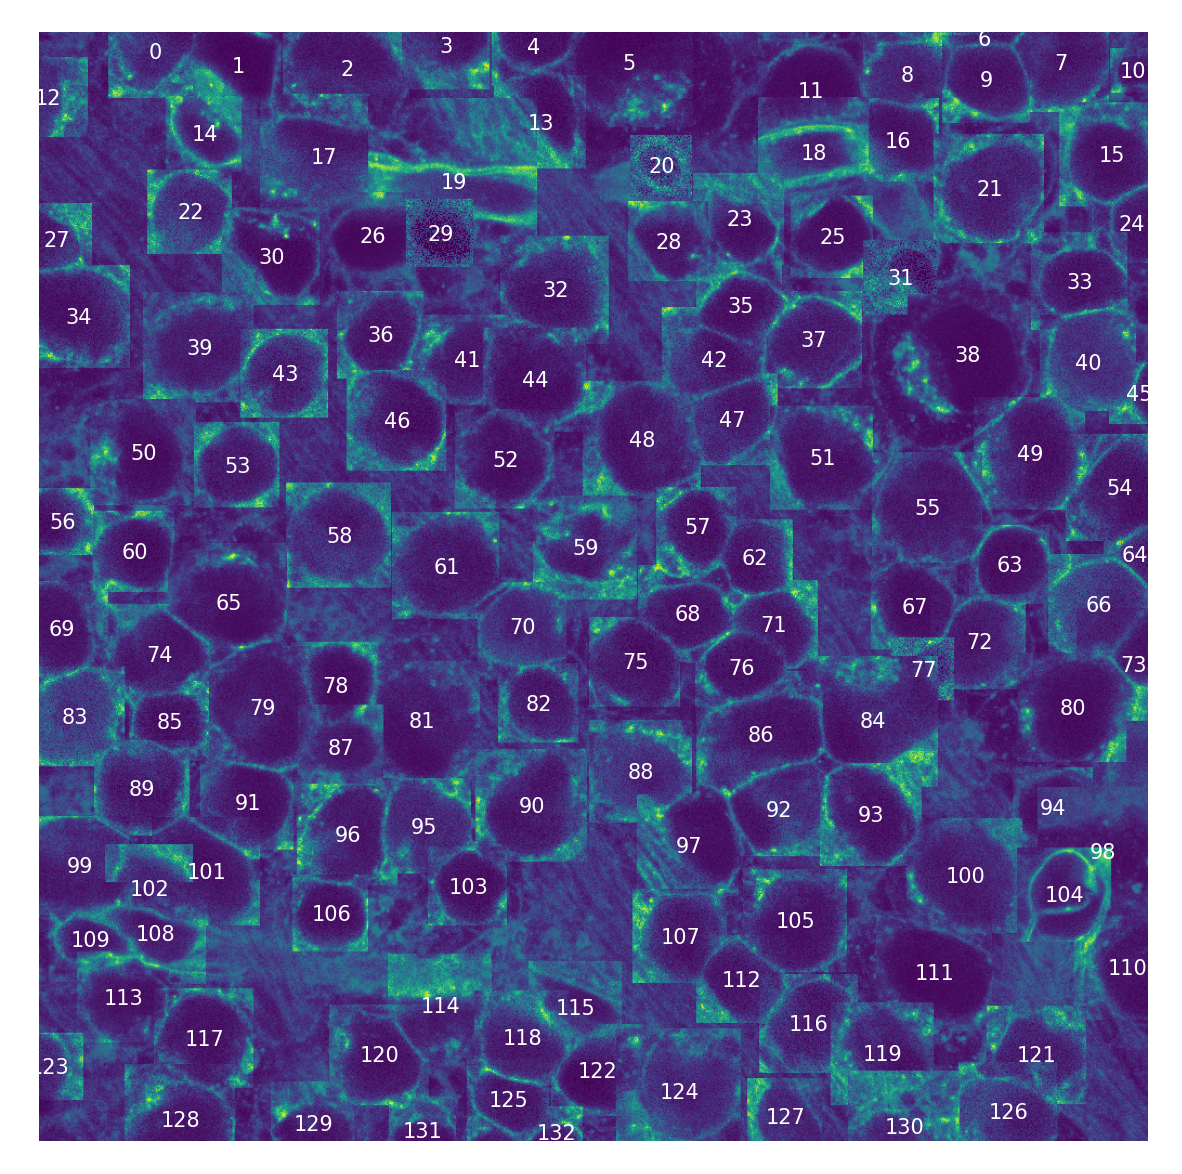

In [7]:
WGA_stitcher(DAPI_stack, WGA_stack, DAPI_masks, .15)
plot_maskids(DAPI_coords, text_color= 'white')

# Visualizations

In [8]:
def upload_training_cells(DAPI_stack, WGA_stack, single_mask, z_sep):
        
        sq_maski = square_mask(single_mask)

        _, _, comzi = nucleus_com(DAPI_stack, single_mask) # Gets the nucleus stack of the middle of the cell

        #Looking for .5 microns above and below
        above_and_below = .6 // z_sep

        max_slice = int(comzi + above_and_below)
        min_slice = int(comzi - above_and_below)
        min_row, min_col, max_row, max_col = regionprops(sq_maski.astype(int))[0].bbox
        '''
        No longer finding the max_proj, just using the middle slice
        '''

        # Finding the middle of the cell
        sq_WGA_stack = WGA_stack[comzi, min_row:max_row, min_col:max_col]
        sq_WGA_slice = sq_WGA_stack

        #sq_WGA_stack = WGA_stack[min_slice: max_slice, min_row:max_row, min_col:max_col]
        #sq_WGA_slice = ~auto_brightness_contrast(max_proj(~sq_WGA_stack)) # Need to add ~ to invert intensities, then ~ to revert back to normal
        
        sq_DAPI_stack = DAPI_stack[min_slice: max_slice, min_row:max_row, min_col:max_col]
        sq_DAPI_slice = auto_brightness_contrast(max_proj(sq_DAPI_stack))

        return sq_WGA_slice, sq_DAPI_slice

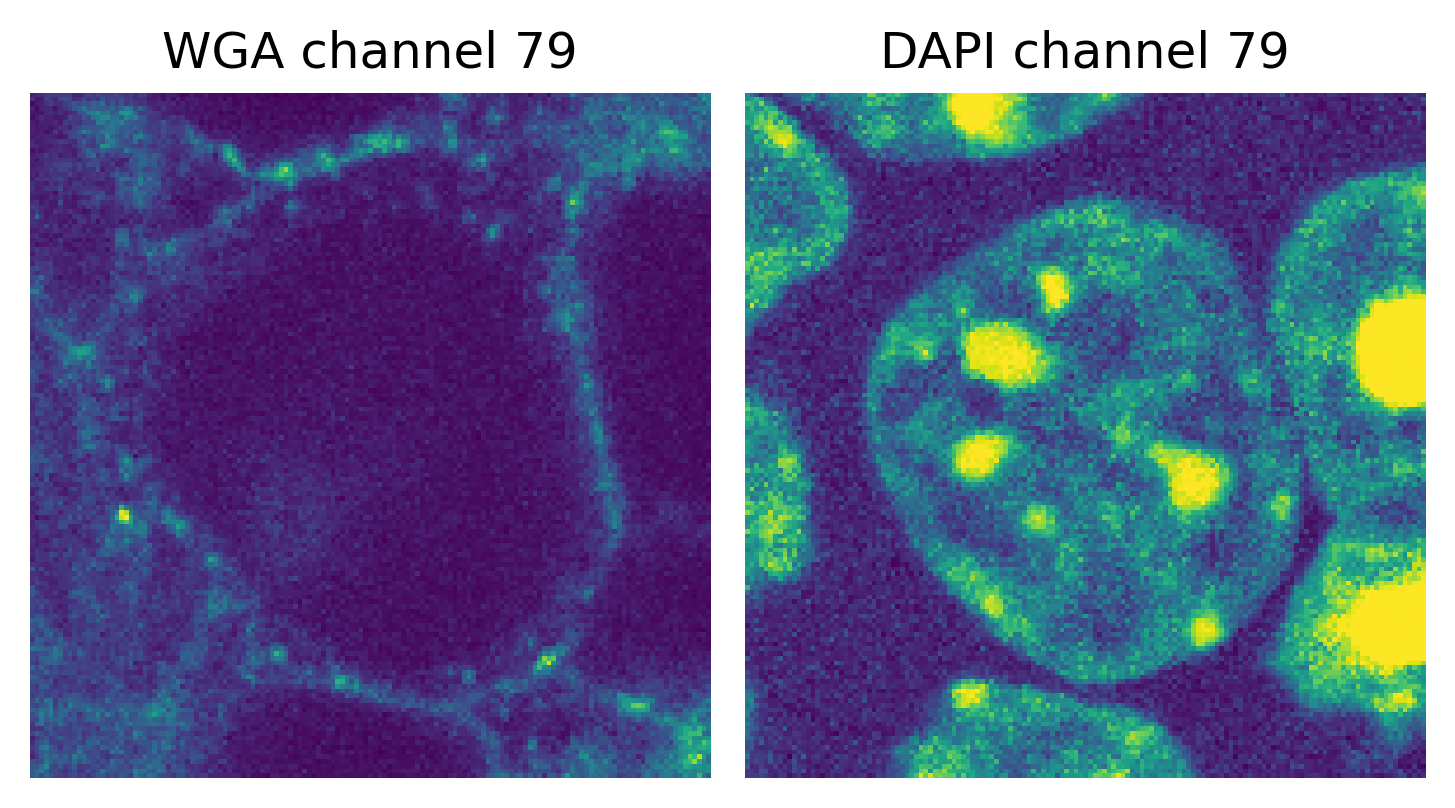

In [9]:
def quickview_channels(mask_id, invert=None):
    global DAPI_masks
    global WGA_stack

    extracted_mask = extract_masks(DAPI_masks, mask_id)

    sq_WGA_slice, sq_DAPI_slice = upload_training_cells(DAPI_stack, WGA_stack, extracted_mask, .15)

    # Invert the specified images
    if invert == "first" or invert == "both":
        sq_WGA_slice = np.max(sq_WGA_slice) - sq_WGA_slice
    if invert == "second" or invert == "both":
        sq_DAPI_slice = np.max(sq_DAPI_slice) - sq_DAPI_slice

    plot_2images(sq_WGA_slice, sq_DAPI_slice, titles = [f'WGA channel {str(mask_id)}', f'DAPI channel {str(mask_id)}'])

    return sq_WGA_slice, sq_DAPI_slice


test = quickview_channels(79, invert = None)

In [10]:
### Model Configuration ###
model_testing = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

73.64781055808787


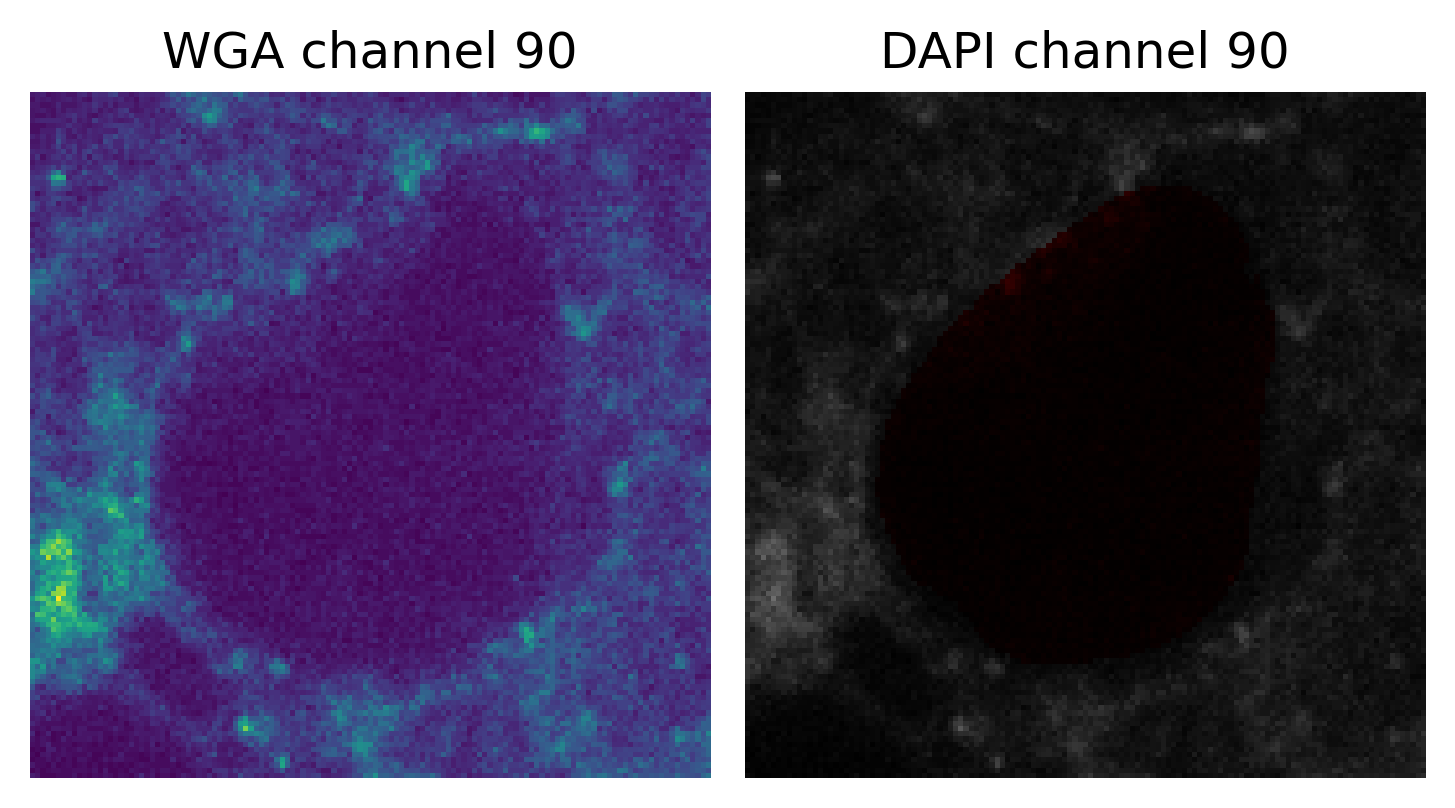

In [76]:
def quickview_channels_model(mask_id):
    global DAPI_masks
    global WGA_stack

    extracted_mask = extract_masks(DAPI_masks, mask_id)
    diam = utils.diameters(extracted_mask)[1][0]
    print(diam)

    sq_WGA_slice, sq_DAPI_slice = upload_training_cells(DAPI_stack, WGA_stack, extracted_mask, .15)

    stack_image = np.stack((sq_WGA_slice, sq_DAPI_slice))

    model = models.CellposeModel(gpu = True, pretrained_model=model_path_dapi)
    masks, flows, styles = model.eval(stack_image, diameter= diam, channels=[0,0])

    overlay = plot.mask_overlay(sq_WGA_slice, masks)

    plot_2images(sq_WGA_slice, overlay, titles = [f'WGA channel {str(mask_id)}', f'DAPI channel {str(mask_id)}'])

    return sq_WGA_slice, sq_DAPI_slice


test = quickview_channels_model(90)

In [22]:
from cellpose import denoise

# dapi_folder = os.path.join(parent_directory, 'DAPI_MPs')

# img_path = os.path.join(dapi_folder, 'max')

f_noise = nd2.ND2File('D:\Lab Analysis PC\DAPI_MPs\max')
image_noise = f.asarray()

deblur_model = denoise.DenoiseModel(gpu = True, pretrained_model= 'deblur_cyto3')
deblur_model.eval(image_noise)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Lab Analysis PC\\DAPI_MPs\\max'

# Code to upload taining cells

In [12]:
# import tifffile as tiff

# test_wga_directory = os.path.join(parent_directory, 'WGA_Cells')
# masks_tot = np.delete(np.unique(DAPI_masks), 0) - 1

# for maski in masks_tot:

#     extraction = extract_masks(DAPI_masks, maski)
    
#     sq_WGA_slice, sq_DAPI_slice = upload_training_cells(DAPI_stack, WGA_stack, extraction, .15)

#     sq_slices = np.stack((sq_DAPI_slice, ~sq_WGA_slice), axis = 0)

#     tiff.imwrite(test_wga_directory + '/' + 'new_' + str(maski) + '.tif', sq_slices)

# Preparing max projections

In [12]:
import tifffile as tiff

script = f'POSIX path of (choose folder default location "{current_directory}")'
#selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
selected_folder = 'D:\Lab Analysis PC\Test Stacks'
mp_DAPI_directory = os.path.join(parent_directory, 'DAPI_MPs')


# Get the list of all .nd2 files in the selected folder
nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]

# Process each .nd2 file
for nd2_file in nd2_files:
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = f.asarray()

    DAPI_stack = to_8bit(image[:,0,:,:].copy())
    mp_DAPI = max_proj(DAPI_stack)

    tiff.imwrite(mp_DAPI_directory + '/' + nd2_file + '_mp' + '.tif', mp_DAPI)

Processing 2007R_GLUT1_647_WGA_594_0002.nd2


C:\Users\Luis\AppData\Local\Temp\ipykernel_13480\2346205098.py:17: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)
